In [81]:
import pandas as pd
from pandas import Series
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# Read File

In [4]:
def convert_datetime(df):
    
    df['Date_Hour'] = pd.to_datetime(df.Date) + pd.to_timedelta(df.Hour, unit='h')
    
    return df

In [5]:
df = pd.read_csv("data/ZonalDemands_2003-2017.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = convert_datetime(df)

df.set_index('Date_Hour', inplace =True)

C:\Users\trevo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#remove zones
df.drop(df.columns[3:],axis = 1, inplace=True)
df.head()

,Date,Hour,Total Ontario
Date_Hour,,,
2003-05-01 01:00:00,2003-05-01,1,13702
2003-05-01 02:00:00,2003-05-01,2,13578
2003-05-01 03:00:00,2003-05-01,3,13411
2003-05-01 04:00:00,2003-05-01,4,13501
2003-05-01 05:00:00,2003-05-01,5,14010


In [7]:
df.drop('Date',axis = 1, inplace = True)

In [8]:
df.drop('Hour',axis = 1, inplace = True)

In [15]:
df.as_matrix()

array([[13702],
       [13578],
       [13411],
       ...,
       [17772],
       [17228],
       [16842]], dtype=int64)

# EDA

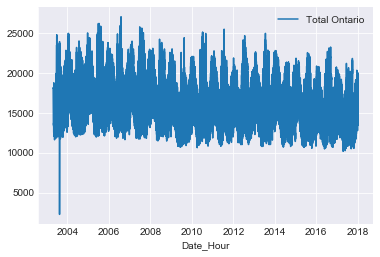

In [40]:
df.plot()

In [53]:
#Remove pre 2004
df = df[8761:]

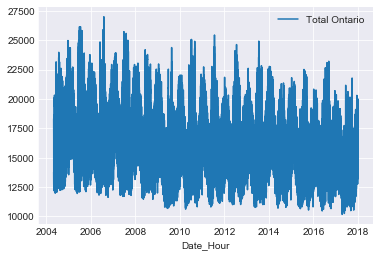

In [42]:
df.plot()

In [43]:
df.describe()

,Total Ontario
count,119856.000000
mean,16358.176587
std,2586.193168
min,10167.000000
25%,14431.000000
50%,16288.000000
75%,18129.000000
max,27005.000000


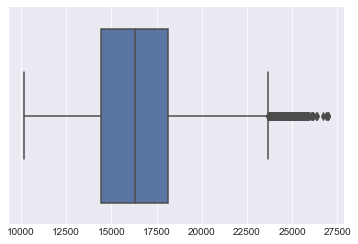

In [44]:
sns.boxplot(df, palette='deep')

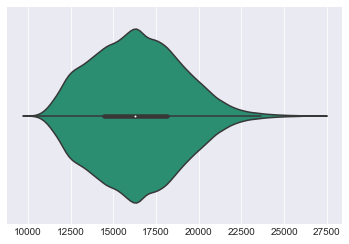

In [45]:
sns.violinplot(df,palette='Dark2')

# RNN Preprocessing

In [128]:
#log to shrink values and induce stationairty 
df_log = pd.Series(df['Total Ontario'].apply(lambda x: np.log(x)))
df_log.head()

Date_Hour
2005-04-30 02:00:00    9.496346
2005-04-30 03:00:00    9.482731
2005-04-30 04:00:00    9.483645
2005-04-30 05:00:00    9.502786
2005-04-30 06:00:00    9.536257
Name: Total Ontario, dtype: float64

In [129]:
ts = np.array(df_log)
num_periods = 24
f_horizon = 1

x_data = ts[:(len(ts)-(len(ts) % num_periods))]
x_batches = x_data.reshape(-1,24,1)

y_data = ts[1:(len(ts)-(len(ts) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1,24,1)

print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

4628
(4628, 24, 1)
[[[9.49634604]
  [9.48273113]
  [9.48364458]
  [9.50278608]
  [9.53625709]
  [9.58376427]
  [9.65771488]
  [9.71299269]
  [9.72740648]
  [9.74296663]
  [9.74402278]
  [9.72597442]
  [9.6995337 ]
  [9.69307512]
  [9.71262966]
  [9.71860271]
  [9.70479268]
  [9.69264306]
  [9.69535576]
  [9.68744374]
  [9.64988479]
  [9.59000893]
  [9.52347087]
  [9.49799744]]

 [[9.47131906]
  [9.45548022]
  [9.45312968]
  [9.46668656]
  [9.47401147]
  [9.51310808]
  [9.57574708]
  [9.62582182]
  [9.63991256]
  [9.65617937]
  [9.6562434 ]
  [9.64264213]
  [9.63344892]
  [9.63443094]
  [9.64478159]
  [9.64672258]
  [9.63867529]
  [9.64743334]
  [9.68973725]
  [9.71038812]
  [9.65848175]
  [9.58514007]
  [9.53741141]
  [9.50799753]]]
[[[9.48273113]
  [9.48364458]
  [9.50278608]
  [9.53625709]
  [9.58376427]
  [9.65771488]
  [9.71299269]
  [9.72740648]
  [9.74296663]
  [9.74402278]
  [9.72597442]
  [9.6995337 ]
  [9.69307512]
  [9.71262966]
  [9.71860271]
  [9.70479268]
  [9.69264306]
  

In [130]:
def test_data(series,forecast,num_periods):
    test_x_setup = ts[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,24,1)
    testY = ts[-(num_periods):].reshape(-1,24,1)
    return testX, testY

X_test, Y_test = test_data(ts,f_horizon,num_periods)
print(X_test.shape)
print(X_test)

(1, 24, 1)
[[[9.71679646]
  [9.684585  ]
  [9.65771488]
  [9.64374485]
  [9.63508509]
  [9.64212279]
  [9.65425667]
  [9.67388569]
  [9.72112599]
  [9.7562049 ]
  [9.77343581]
  [9.78013277]
  [9.78790834]
  [9.78143291]
  [9.77029896]
  [9.76995616]
  [9.78526692]
  [9.83037908]
  [9.89490079]
  [9.87734889]
  [9.83659961]
  [9.81378164]
  [9.78537946]
  [9.75429125]]]


# Build RNN Model

https://mapr.com/blog/deep-learning-tensorflow/

In [131]:
import tensorflow as tf

In [132]:
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [143]:
tf.reset_default_graph()
num_periods = 24
inputs = 1
hidden = 200
output = 1

X = tf.placeholder(tf.float32,[None, num_periods,inputs])
y = tf.placeholder(tf.float32,[None, num_periods,output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden,activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype = tf.float32)

learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output, [-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output,output)
outputs = tf.reshape(stacked_outputs,[-1,num_periods,output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# Run Model

In [144]:
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op,feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep,"\tMSE", mse)
        
    y_pred = sess.run(outputs,feed_dict={X: X_test})
    print(y_pred)

0 	MSE 8119341.5
100 	MSE 86090.55
200 	MSE 2743.093
300 	MSE 124.85457
400 	MSE 101.315216
500 	MSE 83.71179
600 	MSE 76.655945
700 	MSE 75.66073
800 	MSE 75.26607
900 	MSE 70.64095
[[[9.686921 ]
  [9.680773 ]
  [9.686622 ]
  [9.711172 ]
  [9.740113 ]
  [9.730357 ]
  [9.707215 ]
  [9.70283  ]
  [9.732011 ]
  [9.756974 ]
  [9.775174 ]
  [9.776354 ]
  [9.7899065]
  [9.795119 ]
  [9.802407 ]
  [9.799901 ]
  [9.798067 ]
  [9.808209 ]
  [9.835017 ]
  [9.821047 ]
  [9.778118 ]
  [9.740466 ]
  [9.711257 ]
  [9.684953 ]]]


In [146]:
#Remove log
y_pred_trans= np.exp(y_pred)
Y_test_trans = np.exp(Y_test)
y_pred_trans

array([[[16105.581],
        [16006.862],
        [16100.759],
        [16500.932],
        [16985.465],
        [16820.559],
        [16435.77 ],
        [16363.856],
        [16848.398],
        [17274.285],
        [17591.553],
        [17612.318],
        [17852.637],
        [17945.941],
        [18077.209],
        [18031.959],
        [17998.922],
        [18182.4  ],
        [18676.424],
        [18417.32 ],
        [17643.42 ],
        [16991.459],
        [16502.332],
        [16073.91 ]]], dtype=float32)

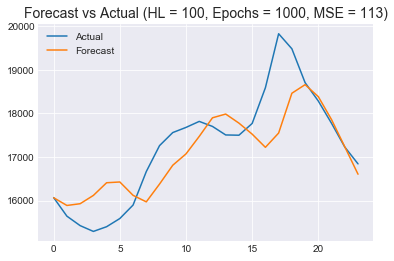

In [145]:
plt.title("Forecast vs Actual (HL = 100, Epochs = 1000, MSE = 113)",fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test_trans)), label = "Actual")
plt.plot(pd.Series(np.ravel(y_pred_trans)), label = "Forecast")
plt.legend()

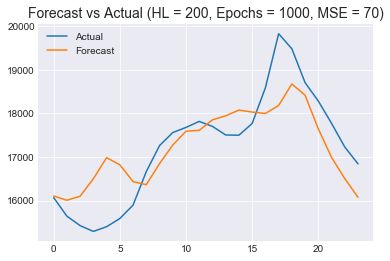

In [147]:
plt.title("Forecast vs Actual (HL = 200, Epochs = 1000, MSE = 70)",fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test_trans)), label = "Actual")
plt.plot(pd.Series(np.ravel(y_pred_trans)), label = "Forecast")
plt.legend()